# Mask R-CNN - Train on Camus Dataset

This notebook shows how to train Mask R-CNN on CAMUS dataset

In [1]:
import os
import sys
import datetime
import numpy as np
import skimage.draw
import SimpleITK as sitk
import matplotlib.pylab as plt
from imgaug import augmenters as iaa



# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.visualize import display_images

# Path to trained weights file
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

class CamusConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Camus"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
#     BACKBONE="resnet101"
#     IMAGE_MIN_DIM = 448
#     IMAGE_MAX_DIM = 448
#     IMAGE_MIN_DIM = 768
#     IMAGE_MAX_DIM = 768

    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448
    IMAGES_PER_GPU = 4
    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + 1 segment
    IMAGE_RESIZE_MODE='square'
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5
    IMAGE_CHANNEL_COUNT= 1
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_MAX_INSTANCES=1
    MEAN_PIXEL = np.array([70.0])
    LOSS_WEIGHTS = {
		"rpn_class_loss": 1.,
		"rpn_bbox_loss": 1.,
		"mrcnn_class_loss": 1.,
		"mrcnn_bbox_loss": 1.,
		"mrcnn_mask_loss": 1.
	}
class CamusInferenceConfig(CamusConfig):
    # Set batch size to 1 to run one image at a time
    BACKBONE="resnet101"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MAX_INSTANCES=3
    # Non-max suppression threshold to filter RPN proposals.
#     RPN_NMS_THRESHOLD = 0.7
#     DETECTION_NMS_THRESHOLD=0.7

#     RPN_NMS_THRESHOLD = 0.95
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_NMS_THRESHOLD = 0.95

    IMAGE_RESIZE_MODE='square'
    LOSS_WEIGHTS = {
		"rpn_class_loss": 1.,
		"rpn_bbox_loss": 1.,
		"mrcnn_class_loss": 1.,
		"mrcnn_bbox_loss": 1.,
		"mrcnn_mask_loss": 1.
	}
    DETECTION_MIN_CONFIDENCE = 0.0
config = CamusConfig()
config.display()
print(config.MEAN_PIXEL)

DEBUG=False

class CamusDataset(utils.Dataset):
    
    def load_camus_images(self, dataset_dir,subset,test=0):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        ratio_VALIDATION=0.8
        # Add classes. We have 1 classe and backround is initialized per default
        self.add_class("camus", 1, "left ventricule")
        self.add_class("camus", 2, "right ventricule")
        self.add_class("camus", 3, "myocarde")
        if(test):
            dataset_dir = os.path.join(dataset_dir, "camus_test")
        else:
            assert subset in ["train", "validation", "test"]
            if subset=="train":
                dataset_dir = os.path.join(dataset_dir, "camus_separated")
            elif subset=="test":
                dataset_dir = os.path.join(dataset_dir, "test")
            else:
                dataset_dir = os.path.join(dataset_dir, "camus_separated")
        #Path to mhd images (not gt)
        print(dataset_dir)
        image_ids = []
        # r=root, d=directories, f = files
       
        
        for r, d, f in sorted(os.walk(dataset_dir)):
            for file in f:    
                if ('ED.mhd' in file) or ('ES.mhd' in file):
                    image_ids.append(os.path.join(r, file))
        numImages=len(image_ids)
        
        
        #stopCount=int(ratio_VALIDATION*numImages)
        stopCount=numImages-200
        print(numImages)
        if subset=="train":
            for image_id in image_ids[:stopCount]:                
                self.add_image(
                    "camus",
                    image_id=image_id[29:48],
                    path=image_id)
        elif subset=="validation":
            for image_id in image_ids[stopCount:]:                
                self.add_image(
                    "camus",
                    image_id=image_id[29:48],
                    path=image_id)
        elif subset=="test":
            for image_id in image_ids:                
                self.add_image(
                    "camus",
                    image_id=image_id[29:48],
                    path=image_id)
        
            
    def load_mask(self, image_id):
        #dataset_dir = "/floyd/input/"#*******************************************************change !!!!!!!!!!!!!!!!!!!!!!!!!!
        info = self.image_info[image_id]
        #mask1_dir = os.path.join(os.path.dirname(info['path']),info['id']+"_gt.mhd")
        mask1_dir = (info['path'][:-4]+"_gt1.mhd")
        mask2_dir = (info['path'][:-4]+"_gt2.mhd")
        mask3_dir = (info['path'][:-4]+"_gt3.mhd")
        mask1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_dir, sitk.sitkFloat32))
        mask2=sitk.GetArrayFromImage(sitk.ReadImage(mask2_dir, sitk.sitkFloat32))
        mask3=sitk.GetArrayFromImage(sitk.ReadImage(mask3_dir, sitk.sitkFloat32))
        mask=np.stack((mask1,mask2,mask3),axis=2)#we stack each mask on each other
        
        
        return mask, np.arange(1,4, dtype=np.int32)
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "camus":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    
    def load_image (self, image_id):
        image=sitk.GetArrayFromImage(sitk.ReadImage(self.image_info[image_id]['path'], sitk.sitkFloat32))
        image=image[0,:,:]
        image=image[..., np.newaxis]
        #image=np.expand_dims(image, axis=2)
        return image
    
    


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

Using TensorFlow backend.


In [2]:
DEBUG=False
dataset_dir = "/floyd/input"
dataset_train = CamusDataset()
dataset_train.load_camus_images(dataset_dir,"train")
dataset_train.prepare()

# Validation dataset
dataset_val = CamusDataset()
dataset_val.load_camus_images(dataset_dir, "validation")
dataset_val.prepare()

dataset_test = CamusDataset()
dataset_test.load_camus_images(dataset_dir, "test")#Test dataset
dataset_test.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
            iaa.Affine(rotate=180),
            iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])
print(DEBUG)
if DEBUG:
    image_id=0
    print(dataset_train.image_ids.shape)
    print(dataset_train.image_ids[0])
    print(dataset_train.image_ids[-1])
    im=dataset_train.load_image(image_id)
    print("image shape:"+str(im.shape))
    m,c = dataset_train.load_mask(image_id)
    print("CLASS:"+str(c))
    print("mask shape:"+str(m.shape))
    
# image_ids = np.random.choice(dataset_train.image_ids, 4)
# print(dataset_train.image_ids)
# for image_id in image_ids:
#     print(image_id)
#     image = dataset_train.load_image(image_id)
#     print("image mean: "+str(np.mean(image)))
#     mask, class_ids = dataset_train.load_mask(image_id)
#     print(image.shape)
#     print("mask shape"+str(mask.shape))
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
          
DEBUG=False
mean=[]
count=0
if DEBUG:
    for image_id in dataset_val.image_ids:
        print(dataset_val.image_reference(image_id))
    

/floyd/input/camus_separated
0
/floyd/input/camus_separated
0
/floyd/input/test
200
Image Count: 0
Class Count: 4
  0. BG                                                
  1. left ventricule                                   
  2. right ventricule                                  
  3. myocarde                                          
False


**Choose weights**

Ground truth Mask and BBOX

In [3]:

infConf=CamusInferenceConfig()
infConf.display()

model = modellib.MaskRCNN(mode="inference", 
                          config=infConf,
                          model_dir=MODEL_DIR)



# def detect (model, image_path=None):
init_with = "custom"  # imagenet, coco, or last or custom

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "custom":
#     model_path = "/floyd/home/logs/mask_rcnn_camus_0042.h5"
#     model_path = "/floyd/home/logs/mask_rcnn_camus_0034.h5"
#     model_path = "/floyd/home/logs/mask_rcnn_camus_0061.h5"best
    model_path="/floyd/home/logs/mask_rcnn_camus3_gray_0072.h5"

    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

Processing 1 images
image                    shape: (843, 512, 1)         min:    0.00000  max:  253.00000  float32
molded_images            shape: (1, 448, 448, 1)      min:  -70.00000  max:  181.60100  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  843.00000  float64
anchors                  shape: (1, 50127, 4)         min:   -0.80993  max:    1.66675  float32
MASKS SHAPE:(843, 512, 3)


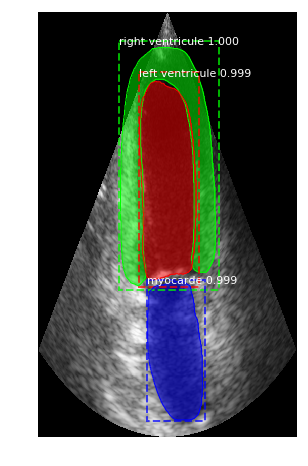

In [4]:
############################################################
#  Detection
############################################################
from mrcnn.model import log
def detect (model, image_path=None):
    
    # Run model detection 
    print("Running on {}".format(args.image))
    # Read image
    image=sitk.GetArrayFromImage(sitk.ReadImage(mask_id, sitk.sitkFloat32))
    # Detect objects
    r = model.detect([image], verbose=1)[0]
        # Save output
        #file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        #skimage.io.imsave(file_name, splash)
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

dataset=dataset_test

image_id = np.random.choice(dataset.image_ids)
# or_image, image_meta, gt_class_id, gt_bbox_resized, gt_mask_resized, padding, scale =modellib.load_image_gt(dataset, infConf,image_id, use_mini_mask=False)
# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)
or_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, infConf, 
                           image_id, use_mini_mask=False)
original_image=dataset.load_image(image_id)
gt_mask,class_ids=dataset.load_mask(image_id)
results = model.detect([original_image], verbose=1)
#segmentation
r = results[0]
# visualize.display_differences(original_image,
#                     gt_box=gt_bbox_resized*scale,gt_class_id=class_ids,gt_mask=mask,
#                     pred_box=r['rois'], pred_class_id=r["class_ids"], pred_score=r["scores"], pred_mask=r["masks"],
#                     class_names=dataset.class_names, 
#                     title="", ax=None,
#                     show_mask=True, show_box=True,
#                     iou_threshold=0.5, score_threshold=0.5)

print("MASKS SHAPE:"+str(r['masks'].shape))
# visualize.display_instances(or_image, gt_bbox, gt_mask, gt_class_id, 
#                                 dataset.class_names, figsize=(8, 8))
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax())

### Segmentation Mask and BBOX

Evaluation : Mean Average Precision mAP

In [ ]:
import PIL
import cv2
from medpy.metric.binary import dc,hd,assd
mask, class_ids = dataset_val.load_mask(image_id)
print(r['masks'].shape)
print(mask.shape)
width=mask.shape[0]
height=mask.shape[1]
dim = (width, height)
resized = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
print(resized.shape)
# print(dice_all(gt_mask,))


In [ ]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, infConf,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, infConf), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [7]:
from medpy.metric.binary import dc,hd,assd

voxel_spacing = [0.308, 0.154]
def assd_all(gt_mask,r):
    res=0.0
    for i in range(3):
        for k in range(3):
            if r["class_ids"][k]-1==i:
                dUni=assd(gt_mask[:,:,i],r['masks'][:,:,k], connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
                if i==0:
                    dOne=dUni
                elif i==1:
                    dTwo=dUni
                else:
                    dThree=dUni
    res+=dOne+dTwo+dThree
    return dOne,dTwo,dThree,res/float(r['masks'].shape[2])
def hd_all(gt_mask,r):
    res=0.0
    for i in range(3):
        for k in range(3):
            if r["class_ids"][k]-1==i:
                dUni=hd(gt_mask[:,:,i],r['masks'][:,:,k], connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
                if i==0:
                    dOne=dUni
                elif i==1:
                    dTwo=dUni
                else:
                    dThree=dUni
    res+=dOne+dTwo+dThree
    return dOne,dTwo,dThree,res/float(r['masks'].shape[2])

def dice_all(gt_mask,r):
    res=0.0
    for i in range(3):
        for k in range(3):
            if r["class_ids"][k]-1==i:
                dUni=dc(gt_mask[:,:,i],r['masks'][:,:,k])
                if i==0:
                    dOne=dUni
                elif i==1:
                    dTwo=dUni
                else:
                    dThree=dUni
    res+=dOne+dTwo+dThree
    return dOne,dTwo,dThree,res/float(r['masks'].shape[2])

dOne,dTwo,dThree,res=hd_all(gt_mask,r)
print("all hd: "+str(res))
print("hd 1: "+str(dOne))

print("hd 2: "+str(dTwo))

print("hd 3: "+str(dThree))

print("mask shape"+str(mask.shape))
_,_,_,assd_example=assd_all(gt_mask,r)
print("all assd: "+str(assd_example))
print("all dice: "+str(dice_all(gt_mask,r)))

all hd: 5.459435388620766
hd 1: 4.975892281792282
hd 2: 7.398413884070017
hd 3: 4.004


NameError: name 'mask' is not defined

Mean Dice:  0.8796531598063512  Std:  0.05365207679736905
Mean ASSD:  2.0214431105671316  Std:  0.8832531277674525
Mean HD:  6.6263211756469955  Std:  2.5509370464553043
empty_mask problems:1
problematic masks ids: [188]


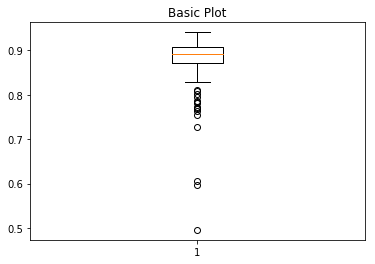

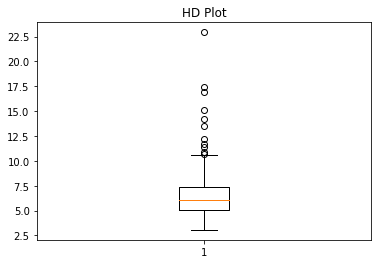

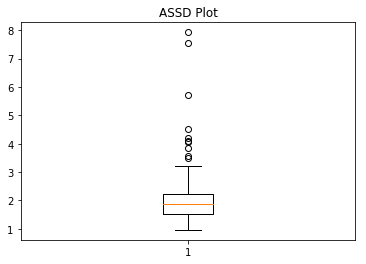

In [8]:
from medpy.metric.binary import dc
dataset=dataset_test

# def post_process(seg):
#     """Keep only the largest predicted structure of seg"""

#     # fill holes
#     seg = binary_fill_holes(seg)

#     ## keep largest structure to remove false positive
#     region_properties = regionprops(label(seg.astype('uint8')))

#     # Find the area of largest region
#     max_area = 0
#     for region in region_properties:
#         if region.area > max_area:
#             max_area = region.area

#     # Remove any regions not belonging to max region
#     for region in region_properties:
#         if region.area < max_area:
#             for point in region.coords:
#                 seg[point] = False

#     return seg

image_ids = dataset.image_ids#np.random.choice(dataset_val.image_ids, 200)
diceBatch=[]
assdBatch=[]
hdBatch=[]
empty_mask=0
problemIDs=[]#absence du masque
for image_id in image_ids:
    # Load image and ground truth data
    image= dataset.load_image(image_id)
    gt_mask,cl_ids=dataset.load_mask(image_id)
    results = model.detect([image], verbose=0)
    r = results[0]
    res=0.0
#     #print(image_id)
#     print(r["masks"].shape)
#     print(gt_mask.shape)
    try:
        dOneD,dTwoD,dThreeD,resD=dice_all(gt_mask,r)
        dOneH,dTwoH,dThreeH,resH=hd_all(gt_mask,r)
        dOneA,dTwoA,dThreeA,resA=assd_all(gt_mask,r)
        diceBatch.append(resD)
        hdBatch.append(resH)
        assdBatch.append(resA)
    except:
        empty_mask+=1
        problemIDs.append(image_id)
        continue
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(diceBatch)

fig2, ax2 = plt.subplots()
ax2.set_title('HD Plot')
ax2.boxplot(hdBatch)

fig3, ax2 = plt.subplots()
ax2.set_title('ASSD Plot')
ax2.boxplot(assdBatch)

print("Mean Dice: ", np.mean(diceBatch)," Std: ",np.std(diceBatch))
print("Mean ASSD: ", np.mean(assdBatch)," Std: ",np.std(assdBatch))
print("Mean HD: ", np.mean(hdBatch)," Std: ",np.std(hdBatch))
print("empty_mask problems:"+str(empty_mask))
print("problematic masks ids: "+str(problemIDs))
#print(diceBatch)

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 1)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [ ]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())